In [1]:
%matplotlib inline

In [26]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from lightkurve import TessLightCurveFile
from astropy.coordinates import SkyCoord
import astropy.units as u
import lightkurve

import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
import theano
from scipy.signal import savgol_filter
from pymc3.step_methods.hmc import quadpotential
from pymc3.variational.callbacks import CheckParametersConvergence, Tracker

import xoflares

In [3]:
print(xo.__version__)
print(theano.__version__)
print(pm.__version__)

0.1.6
1.0.4
3.6


In [4]:
target = 'AU Mic'
lcf = lightkurve.search_lightcurvefile(target).download(quality_bitmask='default',)
lc = lcf.get_lightcurve('PDCSAP_FLUX').normalize()

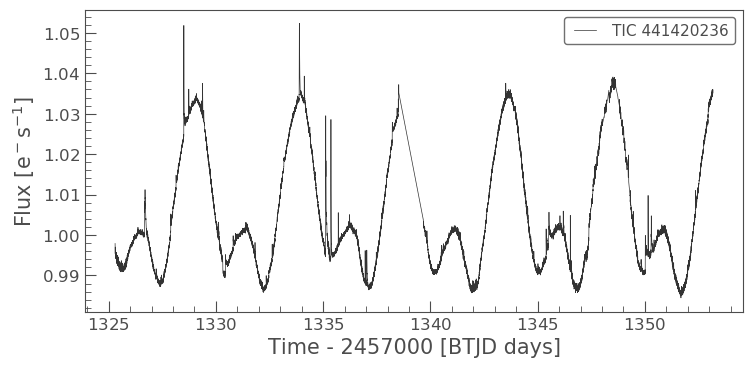

In [5]:
lc_hdr = lcf.header(ext=1)
lc.plot(normalize=False)
# plt.xlim(ref_time-9,ref_time-8)

In [6]:
texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
ref_time = 0.5 * (lc.time.min() + lc.time.max())
flux = (lc.flux - 1.0) * 1e3
time = lc.time
flux_err = lc.flux_err * 1e3
m = np.isfinite(time) & np.isfinite(flux)
time = time[m]
flux = flux[m]
flux_err = flux_err[m]

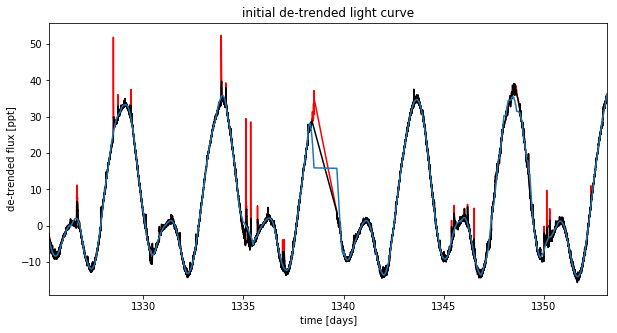

In [7]:
# # Identify outliers
# m = np.ones(len(flux), dtype=bool)
# for i in range(20):
#     y_prime = np.interp(time, time[m], flux[m])
#     smooth = savgol_filter(y_prime, 301, polyorder=3)
#     resid = flux - smooth
#     sigma = np.sqrt(np.mean(resid**2))
#     m0 = resid < sigma*0.5
#     if m.sum() == m0.sum():
#         m = m0
#         break
#     m = m0

smooth = savgol_filter(flux, 501, polyorder=2)
resid = flux - smooth
mask = resid < 3*np.sqrt(np.mean(resid**2))

plt.figure(figsize=(10, 5))
plt.plot(time, flux, "r")
plt.plot(time[mask], flux[mask], "k")
plt.plot(time, smooth)
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(time.min(), time.max());

In [8]:
for j in range(0,28):
    tlim = (time >= time[0]+j) * (time < time[0]+1+j)

    m1 = np.ones(len(flux), dtype=bool)
    for i in range(10):
        y_prime = np.interp(time, time[m1], flux[m1])
        smooth = savgol_filter(y_prime, 501, polyorder=3)
        resid = flux - smooth
        sigma = np.sqrt(np.mean(resid**2))
        m0 = resid < sigma*1
        if m.sum() == m0.sum():
            m1 = m0
            break
        m1 = m0

    mflare = m1
    cads = lc.cadenceno[m] - lc.cadenceno[m][0]
    x = time - ref_time
    y = flux 
    yerr = flux_err

    fidx = cads[~mflare][:-1][np.diff(cads[~mflare]) < 2]
    npts = np.array([])
    i = 0
    n = 1
    while True:
        try:
            if fidx[i + 1] == fidx[i] + n:
                fidx = np.delete(fidx, i + 1)
                n += 1
            else:
                npts = np.r_[npts, n+1]
                i += 1
                n = 1
        except IndexError:
            npts = np.r_[npts, n+1]
            break
    tpeaks = np.array([x[(lc.cadenceno[m] - lc.cadenceno[m][0]) == fidx[i]] for i in range(len(fidx))]).T[0]
    ampls = np.array([resid[(lc.cadenceno[m] - lc.cadenceno[m][0]) == fidx[i]] for i in range(len(fidx))]).T[0]
    fwhms = np.asarray(npts) * (2/1440)
    npeaks = np.shape(tpeaks)[0]

    tpeaks, fwhms, ampls = np.genfromtxt('au-mic-flare-properties.csv', delimiter=',', unpack=True)
    npeaks = np.shape(tpeaks)[0]

    fig, axes = plt.subplots(3, 1, figsize=(13, 11), sharex=True)

    ax = axes[0]
    ax.plot(x[tlim], flux[tlim], ".k", label="data", ms=1)
    ax.plot(x[tlim], smooth[tlim], color="C2", )
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[tlim], flux[tlim] - smooth[tlim], "k", label="de-trended data")


    ax = axes[2]
    ax.plot(x[tlim], flux[tlim] - smooth[tlim], "k", label="de-trended data")
    # ax.plot(x[~mflare * tlim], flux[~mflare * tlim] - smooth[~mflare * tlim], "-r", label="de-trended data")

    ax.plot(tpeaks, ampls, 'or')
    ax.plot(tpeaks+fwhms, ampls, 'ob')

    ax.set_xlim(x[tlim].min(), x[tlim].max())
    ax.minorticks_on()
    fig.tight_layout()
    fig.savefig('tempplots/{}.png'.format(j))
    plt.close('all')

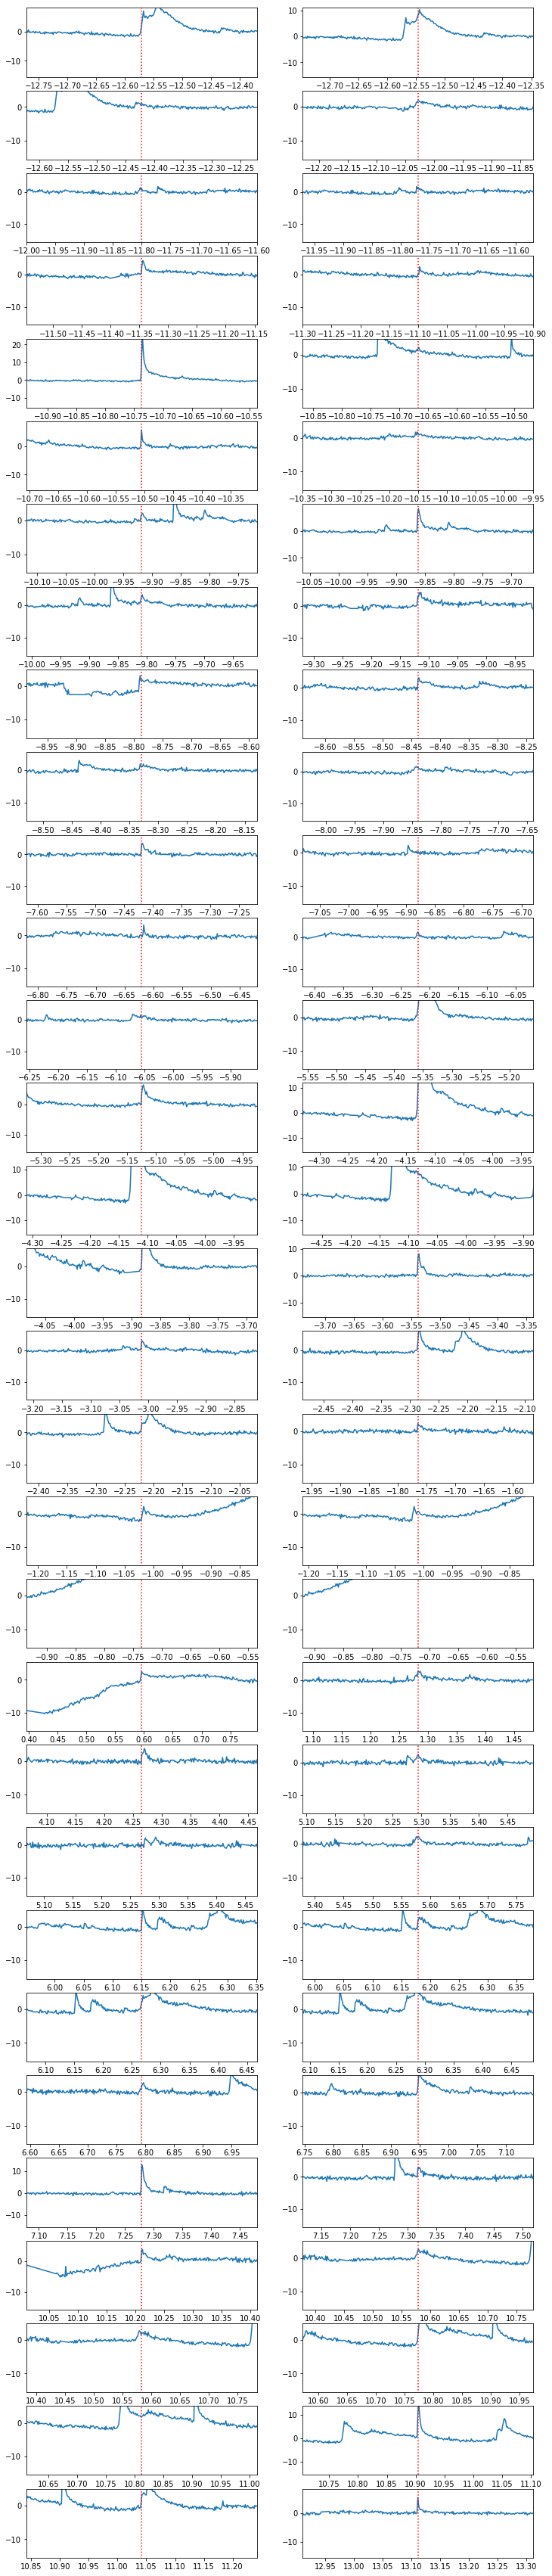

In [9]:
# time = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
# flux = np.ascontiguousarray(flux[m], dtype=np.float64)
# flux_err = np.ascontiguousarray(flux_err[m], dtype=np.float64)

# x = time
# y = flux
# yerr = flux_err
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    ax.plot(x, resid)
    ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    ax.set_ylim(np.min(y), np.max(ampls[i]+3))

In [37]:
# results = xo.estimators.lomb_scargle_estimator(
#     x, y, max_peaks=1, min_period=1.0, max_period=30.0,
#     samples_per_peak=50)

# peak = results["peaks"][0]
# ls_period = peak["period"]
# freq, power = results["periodogram"]
# plt.plot(-np.log10(freq), power, "k")
# plt.axvline(np.log10(ls_period), color="k", lw=4, alpha=0.3)
# plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
# plt.annotate("period = {0:.4f} d".format(ls_period),
#              (0, 1), xycoords="axes fraction",
#              xytext=(5, -5), textcoords="offset points",
#              va="top", ha="left", fontsize=12)
# plt.yticks([])
# plt.xlabel("log10(period)")
# plt.ylabel("power");

ls_period = 4.8692

tpeaks = np.array([1326.67225624, 1326.68197844, 1326.69864507, 1327.89586421, 1328.5055844,
1328.73613914, 1329.31252665, 1329.32363774, 1329.37919314, 1330.12363529,
1330.12919083, 1330.45280077, 1330.45974518, 1330.80418826, 1331.82223907,
1331.8277946 , 1333.69167012, 1333.88750121, 1333.8930567 , 1334.11805408,
1334.1222207 , 1335.11526409, 1335.12081957, 1335.36109427, 1335.70275646,
1336.95690728, 1337.03468415, 1338.22355835, 1338.2305027 , 1343.50815752,
1343.51371293, 1345.39421533, 1345.51087859, 1345.52337822, 1346.19002517,
1346.1969694 , 1346.4677946 , 1346.47612768, 1346.52057079, 1347.39693282,
1347.40387705, 1349.45381144, 1350.01629282, 1350.02323703, 1350.06490231,
1350.14545517, 1350.28572826, 1350.29545015,]) - ref_time

ampls = np.array([4.32564952e-03, 3.21440747e-03, 6.00852955e-03, 2.21224719e-03,
2.63237689e-02, 6.01906968e-03, 5.32023332e-04, 1.96167151e-03,
6.45834983e-03, 2.26582189e-03, 1.92715328e-03, 3.73219704e-03,
1.53482055e-03, 2.51987270e-03, 3.01317005e-03, 1.45998335e-03,
5.51816211e-04, 1.21587041e-02, 1.48640447e-02, 5.15863728e-03,
3.76010504e-03, 2.95507387e-02, 2.13986297e-02, 2.94858587e-02,
6.76131820e-03, 6.59914182e-03, 7.05045153e-03, 1.91342877e-03,
1.61209468e-03, 2.42748762e-03, 2.04425768e-03, 6.40336463e-03,
2.92957356e-03, 2.52232142e-03, 4.76405312e-03, 3.28665868e-03,
6.83556436e-04, 9.98727973e-05, 1.24631272e-02, 2.34869168e-03,
1.59735219e-03, 3.34366964e-03, 4.38939251e-03, 5.22782911e-03,
1.36269597e-03, 9.64380283e-03, 3.30139670e-03, 7.80582932e-03,]) * 1000

fwhms = np.array([0.16805556, 0.0125,     0.10555556, 0.00416667, 0.28194444, 0.00416667,
0.00833333, 0.03472222, 0.07638889, 0.01388889, 0.02222222, 0.0125,
0.02777778, 0.00277778, 0.00833333, 0.00833333, 0.03055556, 0.19583333,
0.13472222, 0.02916667, 0.03472222, 0.23611111, 0.15277778, 0.18888889,
0.05555556, 0.14027778, 0.10555556, 0.00555556, 0.00555556, 0.00972222,
0.01388889, 0.16944444, 0.025     , 0.06388889, 0.03611111, 0.05,
0.01666667, 0.00833333, 0.11111111, 0.00833333, 0.01944444, 0.00277778,
0.11388889, 0.03055556, 0.06805556, 0.12083333, 0.05416667, 0.09305556]) / 10

npeaks = np.shape(tpeaks)[0]

In [11]:
def build_model(mask=None, start=None):
    guess_p_period = 8.463211#, 30.537
    guess_p_t0 = -8.849918#, 2.9955
    guess_p_depth = 0.05#, 0.02
    if mask is None:
        mask = np.ones_like(x, dtype=bool)
    with pm.Model() as model:

        # The mean flux of the time series
        mean = pm.Normal("mean", mu=6, sd=15.0)

        # A jitter term describing excess white noise
        logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr[mask])), sd=5.0)

        # A SHO term to capture long term trends
        logw = pm.Normal("logw", mu=np.log(2*np.pi/10.0), sd=10.0)
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*np.log(2*np.pi/10.0),
                             sd=10)
        logS = pm.Deterministic("logS", logpower - 4 * logw)

#         logS = pm.Normal("logS", mu=0.0, sd=15.0, testval=np.log(np.var(y[mask])))
        
        term1 = xo.gp.terms.SHOTerm(log_S0=logS, log_w0=logw, Q=1/np.sqrt(2))
        
        # The parameters of the RotationTerm kernel
        logamp = pm.Normal("logamp", mu=np.log(np.var(y[mask])), sd=5.0)
        logperiod = pm.Normal("logperiod", mu=np.log(ls_period), sd=0.2)
        period = pm.Deterministic("period", tt.exp(logperiod))
        logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
        logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
        mix = pm.Uniform("mix", lower=0, upper=1.0)
        term2 = xo.gp.terms.RotationTerm(
            log_amp=logamp,
            period=period,
            log_Q0=logQ0,
            log_deltaQ=logdeltaQ,
            mix=mix
        )

        tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.01,
                      testval=tpeaks, shape=npeaks)
        logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=1.5, testval=np.log(fwhms),
                        shape=npeaks)
        logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=1.0, testval=np.log(ampls),
                        shape=npeaks)
        fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
        ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
        
        u_star = xo.distributions.QuadLimbDark("u_star",
                                              testval=np.array([0.24, 0.024]))
        R_star = 0.75, 0.03
        Rho_star = 2
        r_star = pm.Normal("r_star", mu=R_star[0], sd=R_star[1])
        logrho_star = pm.Normal("logrho_star", mu=np.log(Rho_star), sd=0.5)
        rho_star = pm.Deterministic("rho_star", tt.exp(logrho_star))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))
        logP = pm.Normal("logP", mu=np.log(guess_p_period), sd=0.2, shape=1, 
                         testval=np.log(guess_p_period))
        t0 = pm.Normal("t0", mu=guess_p_t0, sd=0.1, shape=1, testval=guess_p_t0)
        
        logror = pm.Bound(pm.Normal, lower=np.log(0.0), upper=np.log(0.3))("logror", 
                                                                            mu=np.log(guess_p_depth),
                                                                            sd=2, shape=1)
        ror = pm.Deterministic("ror", tt.exp(logror))
        b_param = pm.Uniform("b_param", lower=0, upper=1, shape=1, testval=[0.2])
        b = pm.Deterministic("b", b_param * (1 + ror))
        
        ecc = pm.Bound(pm.Beta, lower=0.0, upper=0.6)("ecc", alpha=0.867, beta=3.03, testval=0.03,
                                                     shape=1)
#         ecc = pm.Beta('ecc', alpha=0.867, beta=3.03, testval=[0.1,0.05], shape=2)
        omega = xo.distributions.Angle("omega", shape=1)
    
        p_period = pm.Deterministic("p_period", tt.exp(logP))
        pm.Potential("p_period_prior", tt.switch((p_period < 16.96) | (p_period > 20), 0, -np.inf))
        
        r_pl = pm.Deterministic("r_pl", r_star * ror)
        r_ple = pm.Deterministic("r_ple", r_star * ror / 0.009155)
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            period=p_period, t0=t0, b=b,
            rho_star=rho_star, ecc=ecc, omega=omega)
        light_curve_p = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        
        light_curve_f = xoflares.get_light_curve(x[mask], tpeak, fwhm, ampl, texp=texp, oversample=9)
        
        light_curve = pm.math.sum(light_curve_p, axis=-1) + light_curve_f
        
        pm.Deterministic("light_curve", light_curve)
        model.light_curves = light_curve

        # Set up the Gaussian Process model
        kernel = term1 + term2
        gp = xo.gp.GP(kernel, x[mask], yerr[mask]**2 + tt.exp(logs2), J=6)

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        pm.Potential("loglike", gp.log_likelihood(y[mask] - mean - light_curve))

        # Compute the mean model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict())

        # Optimize to find the maximum a posteriori parameters
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[mean, logs2])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logS, logw])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, mean])
        map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
        map_soln = xo.optimize(start=map_soln, vars=[tpeak])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logamp, logQ0, logdeltaQ, mix])
        map_soln = xo.optimize(start=start, vars=[mean, logs2])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logS, logw])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logamp, logQ0, logdeltaQ, mix])
        map_soln = xo.optimize(start=map_soln, vars=[model.logror, model.b_param, logrho_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logamp, logQ0, logdeltaQ, mix])
        map_soln = xo.optimize(start=map_soln, vars=[model.logror, model.b_param, logrho_star])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logS, logw])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, mean])
        map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
        map_soln = xo.optimize(start=map_soln, vars=[tpeak])
        map_soln = xo.optimize(start=map_soln, vars=[tpeak,fwhm, ampl])
    return model, map_soln

model0, map_soln0 = build_model()

/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

optimizing logp for variables: ['logs2', 'mean']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -44884.01206409813 -> -22237.43167397048
optimizing logp for variables: ['logw', 'logpower', 'logs2', 'mean']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


message: Optimization terminated successfully.
logp: -22237.43167397048 -> -15998.543392971244


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

optimizing logp for variables: ['mean', 'logFwhm']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -15998.543392971244 -> -13665.016168194083
optimizing logp for variables: ['mean', 'logAmpl']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -13665.016168194083 -> -13366.16449113617
optimizing logp for variables: ['logAmpl', 'logFwhm']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -13366.16449113617 -> -13066.757159480727


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


optimizing logp for variables: ['tpeak']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -13066.757159480727 -> -12510.368771615409
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logamp', 'logs2', 'mean']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


message: Optimization terminated successfully.
logp: -12510.368771615409 -> -11969.575965930428
optimizing logp for variables: ['logs2', 'mean']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -44884.01206409813 -> -22237.43167397048
optimizing logp for variables: ['logw', 'logpower', 'logs2', 'mean']
message: Optimization terminated successfully.
logp: -22237.43167397048 -> -15998.543392971244
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logamp', 'logs2', 'mean']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -15998.543392971244 -> -15798.441398981311
optimizing logp for variables: ['logrho_star', 'b_param_interval__', 'logror_upperbound__']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Optimization terminated successfully.
logp: -15798.441398981313 -> -15647.638612543093
optimizing logp for variables: ['t0', 'logP']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -15647.638612543093 -> -15646.75281141981
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logamp', 'logs2', 'mean']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -15646.75281141981 -> -15602.630503625975
optimizing logp for variables: ['logrho_star', 'b_param_interval__', 'logror_upperbound__']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Optimization terminated successfully.
logp: -15602.630503625982 -> -15602.488953116412
optimizing logp for variables: ['logs2', 'mean']
message: Optimization terminated successfully.
logp: -15602.488953116412 -> -15602.488951858637
optimizing logp for variables: ['logw', 'logpower', 'logs2', 'mean']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -15602.488951858637 -> -15379.145199581728
optimizing logp for variables: ['mean', 'logFwhm']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -15379.145199581728 -> -12981.373680586397
optimizing logp for variables: ['mean', 'logAmpl']
message: Optimization terminated successfully.
logp: -12981.373680586397 -> -12614.721182718216
optimizing logp for variables: ['logAmpl', 'logFwhm']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -12614.721182718216 -> -12371.054871822374
optimizing logp for variables: ['tpeak']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -12371.054871822374 -> -11845.454147512573
optimizing logp for variables: ['logAmpl', 'logFwhm', 'tpeak']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -11845.454147512573 -> -11834.149905950373


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


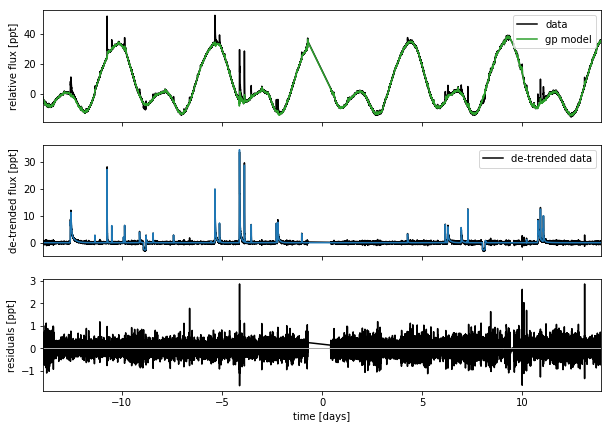

In [12]:
def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = xo.utils.eval_in_model(model.pred, soln, model=model)
    gp_mod += soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    light_curve = xo.utils.eval_in_model(model.light_curves, soln, model=model)

    mod = light_curve
    ax.plot(x[mask], mod,)
    ax.legend(fontsize=10)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + light_curve
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(model0, map_soln0);

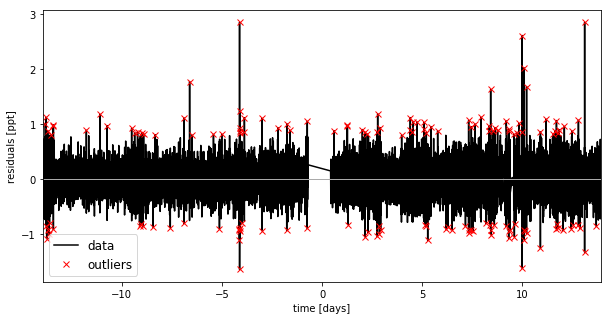

In [13]:
mod = map_soln0["pred"] + map_soln0["mean"] + map_soln0["light_curve"]
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

optimizing logp for variables: ['logs2', 'mean']
message: Optimization terminated successfully.
logp: -11834.149905950373 -> -11525.079546984327
optimizing logp for variables: ['logw', 'logpower', 'logs2', 'mean']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -11525.079546984327 -> -10225.637453235913
optimizing logp for variables: ['mean', 'logFwhm']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -10225.637453235913 -> -10040.982713947868
optimizing logp for variables: ['mean', 'logAmpl']
message: Optimization terminated successfully.
logp: -10040.982713947868 -> -9941.268257363048
optimizing logp for variables: ['logAmpl', 'logFwhm']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -9941.268257363048 -> -9892.273220441752
optimizing logp for variables: ['tpeak']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -9892.273220441752 -> -9855.793073888082
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logamp', 'logs2', 'mean']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -9855.793073888082 -> -9849.509825907395
optimizing logp for variables: ['logs2', 'mean']
message: Optimization terminated successfully.
logp: -11834.149905950373 -> -11525.079546984327
optimizing logp for variables: ['logw', 'logpower', 'logs2', 'mean']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -11525.079546984327 -> -10225.637453235913
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logamp', 'logs2', 'mean']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Optimization terminated successfully.
logp: -10225.637453235913 -> -10224.437823755223
optimizing logp for variables: ['logrho_star', 'b_param_interval__', 'logror_upperbound__']
message: Optimization terminated successfully.
logp: -10224.437823755245 -> -10223.753902171715
optimizing logp for variables: ['t0', 'logP']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -10223.753902171715 -> -10221.16713869697
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logamp', 'logs2', 'mean']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -10221.167138696988 -> -10221.166950341005
optimizing logp for variables: ['logrho_star', 'b_param_interval__', 'logror_upperbound__']
message: Optimization terminated successfully.
logp: -10221.16695034103 -> -10220.95946282828
optimizing logp for variables: ['logs2', 'mean']
message: Optimization terminated successfully.
logp: -10220.95946282828 -> -10220.959458038229
optimizing logp for variables: ['logw', 'logpower', 'logs2', 'mean']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -10220.959458038229 -> -10220.171480739027
optimizing logp for variables: ['mean', 'logFwhm']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -10220.171480739027 -> -10036.26990436048
optimizing logp for variables: ['mean', 'logAmpl']
message: Optimization terminated successfully.
logp: -10036.26990436048 -> -9936.09917151458
optimizing logp for variables: ['logAmpl', 'logFwhm']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -9936.09917151458 -> -9886.233693824623
optimizing logp for variables: ['tpeak']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -9886.233693824623 -> -9844.413267415657
optimizing logp for variables: ['logAmpl', 'logFwhm', 'tpeak']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -9844.413267415657 -> -9844.374636624745


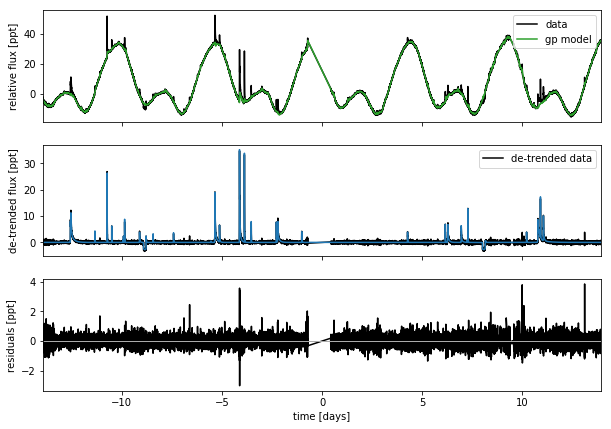

In [14]:
model, map_soln1 = build_model(mask=None, start=map_soln0)
fig = plot_light_curve(model, map_soln1, mask=None)
# fig.savefig('gp-map-aumic.png', dpi=200)

In [15]:
with model:
    map_soln2 = xo.optimize(start=map_soln1,)

/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


optimizing logp for variables: ['omega_angle__', 'ecc_interval__', 'b_param_interval__', 'logror_upperbound__', 't0', 'logP', 'logrho_star', 'r_star', 'u_star_quadlimbdark__', 'logAmpl', 'logFwhm', 'tpeak', 'mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp', 'logpower', 'logw', 'logs2', 'mean']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

message: Desired error not necessarily achieved due to precision loss.
logp: -9844.374636624765 -> -9844.358232607414


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


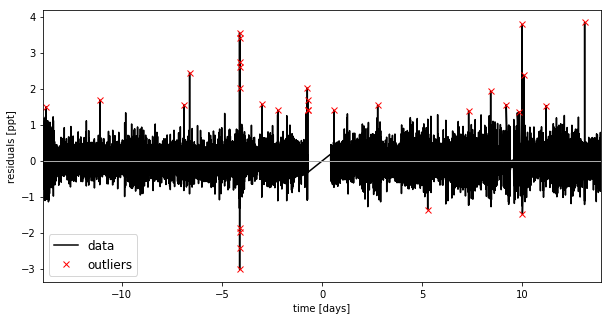

In [16]:
mod = map_soln2["pred"] + map_soln2["mean"] + map_soln2["light_curve"]
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 7 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

No handles with labels found to put in legend.


(-15, 10)

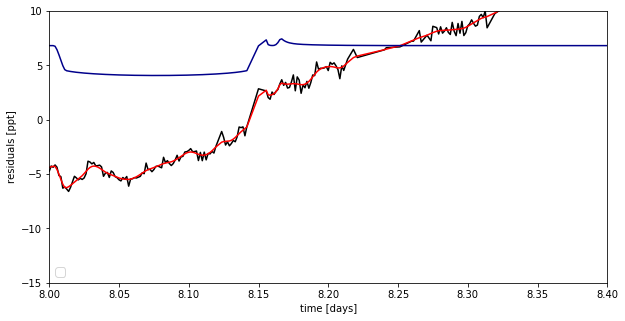

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(x[mask], y[mask], "-k",)
plt.plot(x, map_soln2["pred"] + map_soln2["mean"] + map_soln2["light_curve"], "red",)
plt.plot(x, map_soln2["mean"] + map_soln2["light_curve"], "k", color='darkblue')
# plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(-9.+17, -8.6+17)
# plt.xlim(7.7, 8.5)
plt.ylim(-15, 10)

In [18]:
# model, map_soln = build_model(mask=mask, start=map_soln2)
# fig = plot_light_curve(model, map_soln, mask=mask)
# cb = [
#         pm.callbacks.CheckParametersConvergence(
#             tolerance=1e-2, diff='absolute'),
#         pm.callbacks.CheckParametersConvergence(
#             tolerance=1e-2, diff='relative'),
# ]

# with model:
#     mean_field = pm.fit(method='advi', start=map_soln2,  n=100000)

sampler = xo.PyMC3Sampler(finish=1000, start=100, window=200)
with model:
    burnin = sampler.tune(tune=3000, start=map_soln2, step_kwargs=dict(target_accept=0.9), )

/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

In [21]:
# sampler = xo.PyMC3Sampler(window=200, start=200, finish=800)
# with model:
#     burnin = sampler.tune(tune=3000, start=map_soln, step_kwargs=dict(target_accept=0.9), chains=2)

# # with model:
# #     step = pm.NUTS(potential=potential, target_accept=0.9)
# #     trace = pm.sample(draws=3000, tune=3000, step=step, start=map_soln)

# with model:
#     trace = mean_field.sample(3000)

with model:
    trace = sampler.sample(draws=3000)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega, ecc, b_param, logror, t0, logP, logrho_star, r_star, u_star, logAmpl, logFwhm, tpeak, mix, logdeltaQ, logQ0, logperiod, logamp, logpower, logw, logs2, mean]
Sampling 4 chains: 100%|██████████| 12000/12000 [231:21:21<00:00, 144.21s/draws]   
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
# start, step = sampler._get_start_and_step()
# with model:
#     step = pm.NUTS(potential=step.potential, target_accept=0.9)
#     trace = pm.sample(draws=2000, tune=200, step=step, start=start)

In [ ]:
# pm.summary(trace, varnames= ['mean', 'logs2', 'logS', 'logw', 'logamp', 'logperiod', 'logQ0', 'logdeltaQ',
# #  'tpeak',
# #  'logFwhm',
# #  'logAmpl',
#  'period', 'mix'], alpha=0.317)


# with model:
#     advi = pm.FullRankADVI()


In [ ]:
# mean_field.bij.rmap(mean_field.mean.eval())
mean_field.bij.rmap(mean_field.std.eval())

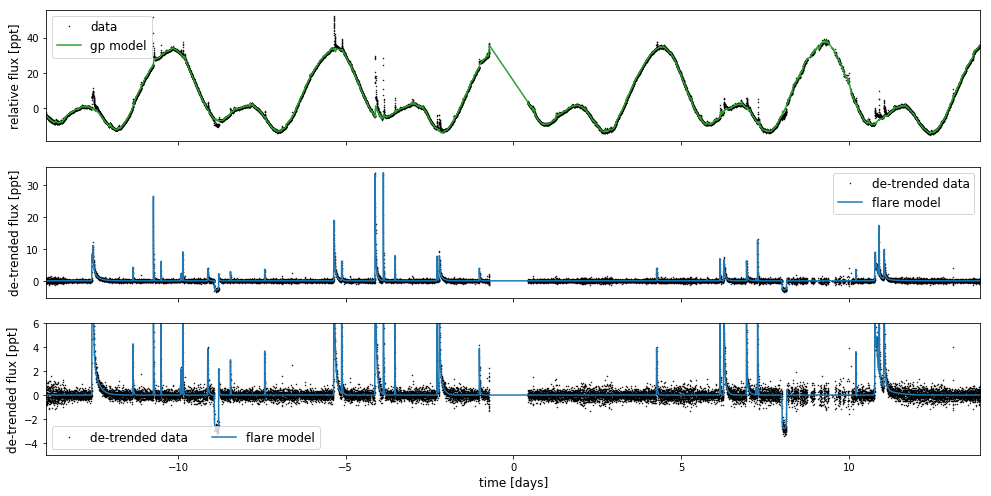

In [40]:
fig, axes = plt.subplots(3, 1, figsize=(14, 7), sharex=True)

ax = axes[0]
ax.plot(x, y, ".k", label="data", ms=1)
gp_mod = np.median(trace['pred'], axis=0)
gp_mod += np.median(trace["mean"])
ax.plot(x, gp_mod, color="C2", label="gp model")
ax.legend(fontsize=12)
ax.set_ylabel("relative flux [ppt]", fontsize=12)

ax = axes[1]
ax.plot(x, y - gp_mod, ".k", label="de-trended data", ms=1)
light_curve = np.median(trace['light_curve'], axis=0)

mod = light_curve
ax.plot(x, mod, label='flare model')
ax.legend(fontsize=12)
ax.set_ylabel("de-trended flux [ppt]", fontsize=12)

ax = axes[2]
# mod = gp_mod + light_curve
# ax.plot(x, y - mod, "k")
# ax.axhline(0, color="#aaaaaa", lw=1)
# ax.set_ylabel("residuals [ppt]", fontsize=12)
ax.plot(x, y - gp_mod, ".k", label="de-trended data", ms=1)
ax.plot(x, mod, label='flare model')

ax.legend(fontsize=12, loc=3, ncol=2)
ax.set_ylabel("de-trended flux [ppt]", fontsize=12)
ax.set_ylim(-5,6)

ax.set_xlim(x.min(), x.max())
ax.set_xlabel("time [days]", fontsize=12)

plt.tight_layout()
fig.savefig('aumic-flares-lim.png', dpi=200)

Prot = 4.866342235371586 +0.0467050744518156 - 0.04337104162422545


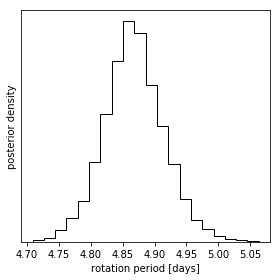

In [41]:
fig, axes = plt.subplots(1,1, figsize=[4, 4])
ax = axes
ax.hist( trace['period'], bins=20, histtype='step', color="k")
plt.yticks([])

ax.set_xlabel("rotation period [days]")
ax.set_ylabel("posterior density");

plt.tight_layout()
fig.savefig('aumic-rotation.png', dpi=200)
q = np.percentile(trace['period'], [16,50,84])
print('Prot = {} +{} - {}'.format(q[1], q[2] - q[1], q[1]-q[0]))

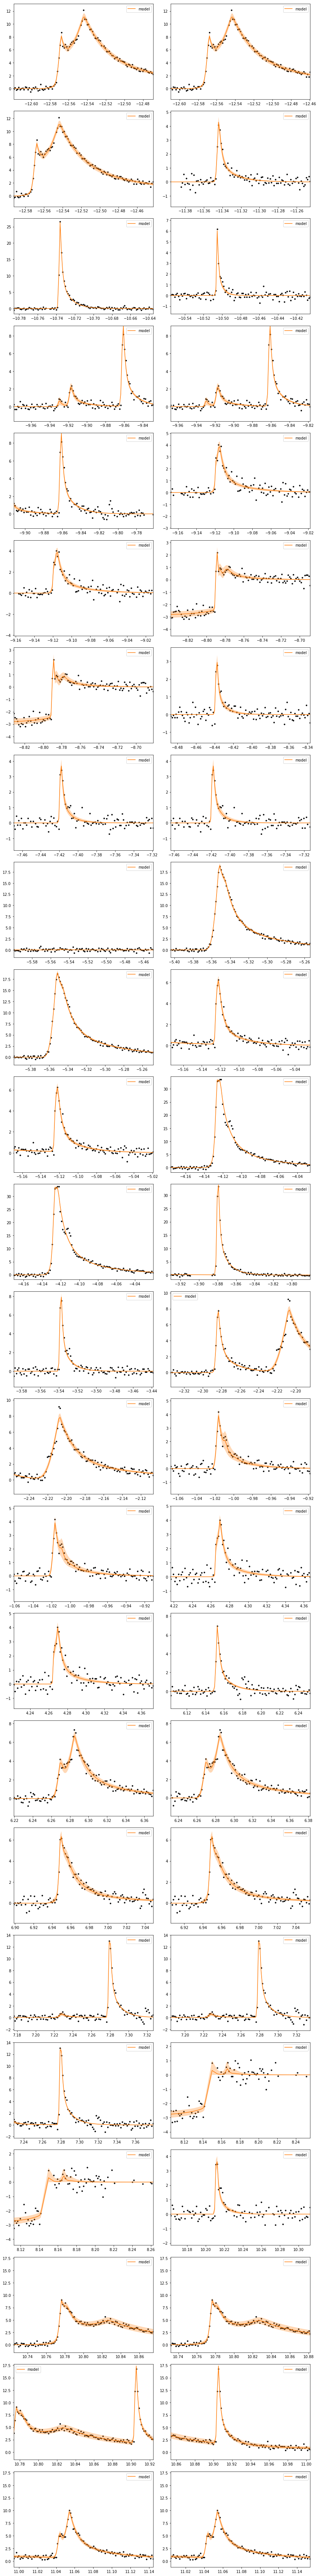

In [42]:
flc =  np.percentile(trace['light_curve'], [16, 50, 84], axis=0)
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks*2])
axes = axes.flatten()
for i in range(npeaks):
    timemask = (x >= tpeaks[i]-0.2) * (x < tpeaks[i]+0.2)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask]-gp_mod[timemask], '.k')
    ax.plot(x[timemask], flc[1][timemask], color="C1", label="model")
    art = ax.fill_between(x[timemask], flc[0][timemask],
                          flc[2][timemask], color="C1", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(tpeaks[i]-0.05, tpeaks[i]+0.1)
    ax.set_ylim(np.min(y[timemask]-gp_mod[timemask]) - 1, 1 + np.max(y[timemask]-gp_mod[timemask]))
    ax.legend()
    
fig.tight_layout()
fig.savefig('flare-model-aumic.png')

In [44]:
n = 0
resid = y[mask] - trace["pred"] - trace["mean"][:, None]
p = np.median(trace["p_period"][:, n])
t0 = np.median(trace["t0"][:, n])
x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
plt.plot(x_fold, np.percentile(resid, [16], axis=0), ".C2", label="data", zorder=-1000)
plt.plot(x_fold, np.percentile(resid, [50], axis=0), ".C2", label="data", zorder=-1000)
plt.plot(x_fold, np.percentile(resid, [84], axis=0), ".C2", label="data", zorder=-1000)

ValueError: operands could not be broadcast together with shapes (18063,) (12000,18094) 

In [45]:
pred = np.percentile(resid, [16, 50, 84], axis=0)
plt.plot(x_fold, pred[1], ".C2", label="data", zorder=-1000)
plt.xlim(-0.3, 0.3)

NameError: name 'x_fold' is not defined

In [25]:
map_soln0

{'mean': array(6.52882114),
 'logs2': array(-2.39280003),
 'logS': array(-2.98246078),
 'logw': array(3.37673192),
 'logamp': array(5.03765618),
 'logperiod': array(1.58292243),
 'logQ0': array(2.93485094),
 'logdeltaQ': array(9.9145813),
 'mix_interval__': array(-1.18581046),
 'u_star_quadlimbdark__': array([-0.57536414, -0.69314718]),
 'r_star': array(0.75),
 'logrho_star': array(-0.10536052),
 'logP': array([2.82825524, 3.42921204]),
 't0': array([-8.82244677,  2.9953215 ]),
 'logror_upperbound__': array([0.68895411, 1.26911893]),
 'b_param_interval__': array([-0.78097465, -0.67497811]),
 'ecc_interval__': array([-1.94591015, -1.94591015]),
 'omega_angle__': array([[0., 0.],
        [1., 1.]]),
 'period': array(4.86916485),
 'mix': array(0.23400907),
 'u_star': array([0.4, 0.2]),
 'rho_star': array(0.9),
 'logror': array([-3.19560421, -4.76168937]),
 'ror': array([0.04094178, 0.00855115]),
 'b_param': array([0.31410987, 0.33738306]),
 'b': array([0.32697008, 0.34026807]),
 'ecc': ar

In [1]:
# import corner
# varnames = ['ampl', 'tpeak']
# samples = pm.trace_to_dataframe(trace, varnames=varnames)
# corner.corner(samples);


# ['mean',
#  'logs2',
#  'logS',
#  'logw',
#  'logamp',
#  'logperiod',
#  'logQ0',
#  'logdeltaQ',
#  'mix_interval__',
#  'tpeak',
#  'logFwhm',
#  'logAmpl',
#  'period',
#  'mix',
#  'fwhm',
#  'ampl',
#  'light_curve',
#  'pred']

hello


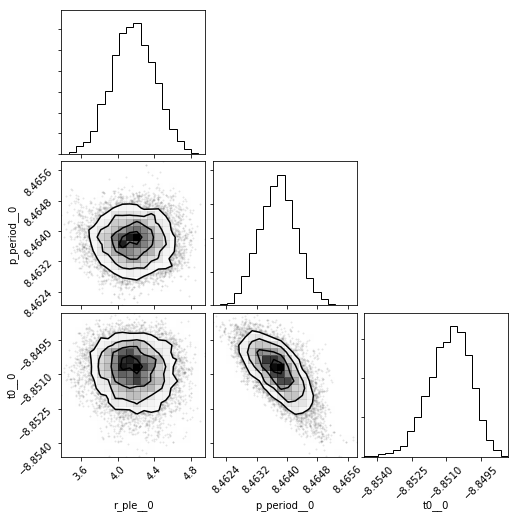

In [47]:
import corner
varnames = ["r_ple", "p_period", 't0']
samples = pm.trace_to_dataframe(trace, varnames=varnames)
corner.corner(samples);


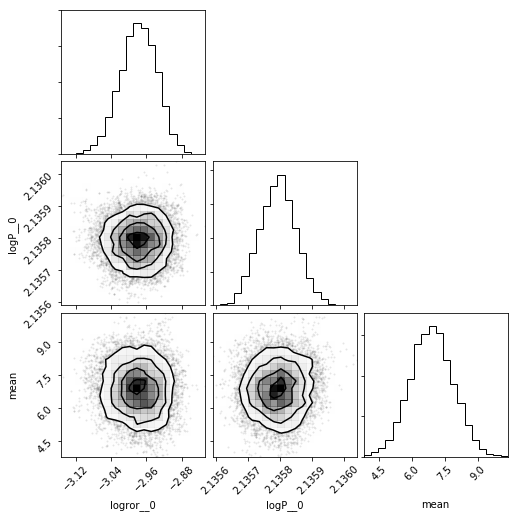

In [46]:
import corner
varnames = ["logror", "logP", 'mean']
samples = pm.trace_to_dataframe(trace, varnames=varnames)
corner.corner(samples);

In [48]:
pm.save_trace(trace)

'.pymc_7.trace'

In [36]:
del model0

In [157]:
for j in range(0,28):
    tlim = (x >= x[0]+j) * (x < x[0]+1+j)

    m1 = np.ones(len(flux), dtype=bool)
    for i in range(10):
        y_prime = np.interp(time, time[m1], flux[m1])
        smooth = savgol_filter(y_prime, 501, polyorder=3)
        resid = flux - smooth
        sigma = np.sqrt(np.mean(resid**2))
        m0 = resid < sigma*1
        if m.sum() == m0.sum():
            m1 = m0
            break
        m1 = m0

    mflare = m1
    cads = lc.cadenceno[m] - lc.cadenceno[m][0]
    x = time - ref_time
    y = resid #  we're working with the data with a savgol subtracted

    fidx = cads[~mflare][:-1][np.diff(cads[~mflare]) < 2]
    npts = np.array([])
    i = 0
    n = 1
    while True:
        try:
            if fidx[i + 1] == fidx[i] + n:
                fidx = np.delete(fidx, i + 1)
                n += 1
            else:
                npts = np.r_[npts, n+1]
                i += 1
                n = 1
        except IndexError:
            npts = np.r_[npts, n+1]
            break
    tpeaks = np.array([x[(lc.cadenceno[m] - lc.cadenceno[m][0]) == fidx[i]] for i in range(len(fidx))]).T[0]
    ampls = np.array([resid[(lc.cadenceno[m] - lc.cadenceno[m][0]) == fidx[i]] for i in range(len(fidx))]).T[0]
    fwhms = np.asarray(npts) * (2/1440)
    npeaks = np.shape(tpeaks)[0]

    tpeaks, fwhms, ampls = np.genfromtxt('au-mic-flare-properties.csv', delimiter=',', unpack=True)

    fig, axes = plt.subplots(3, 1, figsize=(13, 11), sharex=True)

    ax = axes[0]
    ax.plot(x[tlim], flux[tlim], ".k", label="data", ms=1)
    ax.plot(x[tlim], smooth[tlim], color="C2", )
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[tlim], flux[tlim] - smooth[tlim], "k", label="de-trended data")


    ax = axes[2]
    ax.plot(x[tlim], flux[tlim] - smooth[tlim], "k", label="de-trended data")
    # ax.plot(x[~mflare * tlim], flux[~mflare * tlim] - smooth[~mflare * tlim], "-r", label="de-trended data")

    ax.plot(tpeaks, ampls, 'or')
    ax.plot(tpeaks+fwhms, ampls, 'ob')

    ax.set_xlim(x[tlim].min(), x[tlim].max())
    ax.minorticks_on()
    fig.tight_layout()
    fig.savefig('tempplots/{}.png'.format(j))
    plt.close('all')

In [158]:
!

In [13]:
flux_err * 1.E3

array([0.21623355, 0.2060531 , 0.20640688, ..., 0.22084115, 0.22095208,
       0.22103585], dtype=float32)

In [40]:
xoflares.eval_get_light_curve(np.arange(0, 10, 2 / 1440), np.array([1, 2, 3, 4]), np.array([0.5, 0.5, 0.5, 2]),
                         np.array([1, 2, 3, 4]), 1, oversample=11)

ValueError: Cannot compute test value: input 0 (timex) of Op InplaceDimShuffle{0,x}(timex) missing default value.  
Backtrace when that variable is created:

  File "/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-40-fba2cb2942ee>", line 2, in <module>
    np.array([1, 2, 3, 4]), 1, oversample=11)
  File "/home/tom/gitcode/xoflares/xoflares/xoflares.py", line 132, in eval_get_light_curve
    timex = tt.dvector('timex')


['mean',
 'logs2',
 'logS',
 'logw',
 'logamp',
 'logperiod',
 'logQ0',
 'logdeltaQ',
 'mix_interval__',
 'tpeak',
 'logFwhm',
 'logAmpl',
 'period',
 'mix',
 'fwhm',
 'ampl',
 'light_curve',
 'pred']

In [34]:
tpeaks

array([-12.571, -12.547, -12.422, -12.028, -11.8  , -11.77 , -11.346,
       -11.1  , -10.737, -10.668, -10.505, -10.15 ,  -9.918,  -9.862,
        -9.809,  -9.119,  -8.786,  -8.439,  -8.329,  -7.84 ,  -7.419,
        -6.88 ,  -6.62 ,  -6.22 ,  -6.055,  -5.359,  -5.125,  -4.129,
        -4.11 ,  -4.083,  -3.882,  -3.539,  -3.011,  -2.286,  -2.221,
        -1.765,  -1.02 ,  -1.01 ,  -0.735,  -0.72 ,   0.596,   1.282,
         4.265,   5.294,   5.27 ,   5.579,   6.151,   6.179,   6.267,
         6.288,   6.794,   6.947,   7.279,   7.318,  10.211,  10.578,
        10.583,  10.773,  10.812,  10.904,  11.042,  13.111])

In [36]:
fwhms

array([0.02222, 0.02361, 0.02917, 0.01278, 0.00694, 0.00694, 0.00694,
       0.00694, 0.02583, 0.00278, 0.00278, 0.002  , 0.00278, 0.0125 ,
       0.00556, 0.01528, 0.02278, 0.00417, 0.00417, 0.00556, 0.00556,
       0.00417, 0.00417, 0.00556, 0.00556, 0.04444, 0.02083, 0.0375 ,
       0.00556, 0.05972, 0.025  , 0.01389, 0.00556, 0.0125 , 0.04167,
       0.00278, 0.00278, 0.00278, 0.00367, 0.00367, 0.00556, 0.00694,
       0.00972, 0.00278, 0.00278, 0.00278, 0.00694, 0.00972, 0.04583,
       0.00278, 0.00694, 0.03333, 0.01528, 0.00556, 0.00833, 0.00417,
       0.00417, 0.0375 , 0.04861, 0.01667, 0.04167, 0.00278])

In [53]:
ampls

array([ 5.225,  7.896,  1.832,  1.781,  2.694,  2.694,  2.694,  2.694,
       20.29 ,  1.8  ,  5.863,  1.8  ,  1.857,  6.794,  2.551,  2.876,
        1.839,  2.427,  2.427,  3.139,  3.139,  2.427,  2.427,  3.139,
        3.139,  2.221,  3.949,  8.874,  8.545,  7.523,  2.52 ,  7.134,
        3.023,  3.111,  2.789,  2.277,  2.277,  2.277,  1.77 ,  1.77 ,
        2.514,  2.644,  1.975,  2.437,  2.437,  1.817,  2.044,  2.037,
        1.954,  1.975,  1.93 ,  2.19 , 12.945,  2.877,  3.563,  2.308,
        1.875,  1.841,  1.989, 10.678,  2.109,  5.391])

In [47]:
q1 = xoflares.get_light_curvenp(x, tpeaks, fwhms, ampls)

In [54]:
tpeaks1 = np.array([1326.67225624, 1326.68197844, 1326.69864507, 1327.89586421, 1328.5055844,
1328.73613914, 1329.31252665, 1329.32363774, 1329.37919314, 1330.12363529,
1330.12919083, 1330.45280077, 1330.45974518, 1330.80418826, 1331.82223907,
1331.8277946 , 1333.69167012, 1333.88750121, 1333.8930567 , 1334.11805408,
1334.1222207 , 1335.11526409, 1335.12081957, 1335.36109427, 1335.70275646,
1336.95690728, 1337.03468415, 1338.22355835, 1338.2305027 , 1343.50815752,
1343.51371293, 1345.39421533, 1345.51087859, 1345.52337822, 1346.19002517,
1346.1969694 , 1346.4677946 , 1346.47612768, 1346.52057079, 1347.39693282,
1347.40387705, 1349.45381144, 1350.01629282, 1350.02323703, 1350.06490231,
1350.14545517, 1350.28572826, 1350.29545015,]) - ref_time

ampls1 = np.array([4.32564952e-03, 3.21440747e-03, 6.00852955e-03, 2.21224719e-03,
2.63237689e-02, 6.01906968e-03, 5.32023332e-04, 1.96167151e-03,
6.45834983e-03, 2.26582189e-03, 1.92715328e-03, 3.73219704e-03,
1.53482055e-03, 2.51987270e-03, 3.01317005e-03, 1.45998335e-03,
5.51816211e-04, 1.21587041e-02, 1.48640447e-02, 5.15863728e-03,
3.76010504e-03, 2.95507387e-02, 2.13986297e-02, 2.94858587e-02,
6.76131820e-03, 6.59914182e-03, 7.05045153e-03, 1.91342877e-03,
1.61209468e-03, 2.42748762e-03, 2.04425768e-03, 6.40336463e-03,
2.92957356e-03, 2.52232142e-03, 4.76405312e-03, 3.28665868e-03,
6.83556436e-04, 9.98727973e-05, 1.24631272e-02, 2.34869168e-03,
1.59735219e-03, 3.34366964e-03, 4.38939251e-03, 5.22782911e-03,
1.36269597e-03, 9.64380283e-03, 3.30139670e-03, 7.80582932e-03,]) * 1000

fwhms1 = np.array([0.16805556, 0.0125,     0.10555556, 0.00416667, 0.28194444, 0.00416667,
0.00833333, 0.03472222, 0.07638889, 0.01388889, 0.02222222, 0.0125,
0.02777778, 0.00277778, 0.00833333, 0.00833333, 0.03055556, 0.19583333,
0.13472222, 0.02916667, 0.03472222, 0.23611111, 0.15277778, 0.18888889,
0.05555556, 0.14027778, 0.10555556, 0.00555556, 0.00555556, 0.00972222,
0.01388889, 0.16944444, 0.025     , 0.06388889, 0.03611111, 0.05,
0.01666667, 0.00833333, 0.11111111, 0.00833333, 0.01944444, 0.00277778,
0.11388889, 0.03055556, 0.06805556, 0.12083333, 0.05416667, 0.09305556])

q2 = xoflares.get_light_curvenp(x, tpeaks1, fwhms1, ampls1)

In [59]:
plt.figure(figsize=[12,8])
plt.plot(x, q1, label='tom')
plt.plot(x, q2, label='emily')
plt.legend()


# plt.plot(x, y)

SyntaxError: invalid syntax (<ipython-input-59-6e729c0242f8>, line 1)

In [20]:
print('hello')

hello


In [25]:
pm.summary(trace, varnames=
          ['mean',
 'logs2',
 'logw',
 'logpower',
 'logamp',
 'logperiod',
 'logQ0',
 'logdeltaQ',
 'tpeak',
 'logFwhm',
 'logAmpl',
 'r_star',
 'logrho_star',
 'logP',
 't0',
 'logS',
 'period',
 'mix',
 'fwhm',
 'ampl',
 'u_star',
 'rho_star',
 'logror',
 'ror',
 'b_param',
 'b',
 'ecc',
 'omega',
 'p_period',
 'r_pl',
 'r_ple',])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,6.882038,0.971941,0.070234,5.040436,8.835828,60.189643,1.016723
logs2,-2.501069,0.020181,0.001117,-2.539707,-2.461923,167.290869,1.016335
logw,4.929673,0.062004,0.003253,4.803829,5.047762,205.340509,1.008877
logpower,13.013742,0.135009,0.007144,12.737517,13.265530,204.962993,1.006077
logamp,5.029663,0.484057,0.038908,4.193202,6.060075,32.466482,1.063667
logperiod,1.582600,0.009639,0.000504,1.562873,1.601606,234.236160,1.014817
logQ0,0.543582,0.416561,0.027768,-0.269230,1.357284,92.777997,1.005246
logdeltaQ,10.340649,4.364948,0.314226,3.710835,19.631135,24.099137,1.114049
tpeak__0,-12.568300,0.000165,0.000008,-12.568634,-12.567978,346.569751,1.018877
tpeak__1,-12.560550,0.003110,0.000254,-12.564832,-12.555179,61.149669,1.028265


In [32]:
npeaks[0]

48